In [1]:
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
import itertools

import seaborn as sns
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.d03_processing.BlinkProcessor import BlinkProcessor
from src.d03_processing.fixations.SignalProcessor import SignalProcessor
from src.d03_processing.fixations.GazeCollision import GazeCollision
from src.d03_processing.fixations.VR_IDT import VR_IDT
from src.d00_utils.TaskObjects import *
from src.d03_processing.fixations.FixationProcessor import FixationProcessor
from src.d03_processing.TimepointProcessor import TimepointProcessor
from src.d01_data.fetch.fetch_timepoints import fetch_timepoints
from src.d03_processing.aoi import collision_sphere_radius

from src.d03_processing.feature_calculate.fix_sacc_calculations import dwell_time
import random

# space for functions
def total_p_trackloss(timepoints, trackloss_column='trackloss'):
    """total proportion of trackloss for viewing period - used to exclude viewings with e.g. > 25%"""
    if timepoints is None:
        # print('None')
        return np.nan
    elif any([len(timepoints) < 1, 'trackloss' not in list(timepoints.columns)]):
        tl = 'trackloss' not in list(timepoints.columns)
        print(f"len: {len(timepoints)}, trackloss?: {tl}")
        return np.nan
    else:
        t_diff = np.append(np.array([0]), np.diff(timepoints.eye_timestamp_ms))
        bools = np.array(timepoints[trackloss_column].to_numpy(), dtype=bool)
        n_trackloss = np.sum(t_diff[bools])
        total = np.sum(t_diff)
        # print(bools[:10])
        # print(t_diff[bools])
        # print(f"n_samples: {np.sum(timepoints[trackloss_column])} n trackloss: {n_trackloss}, total t: {total}")
        return float(n_trackloss/total)
    
        
def get_center(obj, tps, y_adjust=0):
    # display(tps.iloc[:2, :].style)
    row = tps[tps.gaze_object == obj].reset_index(drop=True).iloc[0, :]
    center = (row.object_position_x, row.object_position_z, row.object_position_y + y_adjust) 
    # print(f"{obj}: {row.gaze_object} {center}")
    return center


def viewing_plot(tps, array_objects, gp_lab='table', gp_line=False, ax=None):
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
    camera_pos = np.array([np.nanmean(tps.camera_x), np.nanmean(tps.camera_z), np.nanmean(tps.camera_y)])

    # plot gaze points as points
    x, y, z = tps.gaze_collision_x.to_numpy(),tps.gaze_collision_y.to_numpy(),tps.gaze_collision_z.to_numpy()
    lab = tps.gaze_object == 'Table' if gp_lab=='table' else np.array(tps[gp_lab].to_numpy(), dtype=bool)
    no_lab = np.invert(lab)
    # print(lab)
    # print(no_lab)
    ax.scatter(x[lab], z[lab], y[lab], c='red', s=2, alpha=0.5)
    ax.scatter(x[no_lab], z[no_lab], y[no_lab], c='g', s=2, alpha=0.5)
    if gp_line:
        ax.plot(x, z, y, c='k', linewidth=0.4)

    # draw a cylinder to represent a table
    table_y_scale =  0.06538646
    table_center =  get_center('Table', tps) # center of the cylinder
    camera_vec = table_center - camera_pos
    # print(f"table: {table_center}")
    radius = 0.55  # radius of the cylinder
    height = table_y_scale * 2  # height of the cylinder
    resolution = 20

    # Create the cylinder mesh
    z = np.linspace(table_center[2]-height/2, table_center[2]+height/2, resolution)
    theta = np.linspace(0, 2*np.pi, resolution)
    theta_grid, z_grid = np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + table_center[0]
    y_grid = radius*np.sin(theta_grid) + table_center[1]

    # Create the Poly3DCollection
    verts = []
    for i in range(len(z)-1):
        verts += [list(zip(x_grid[i], y_grid[i], z_grid[i])),
                  list(zip(x_grid[i+1], y_grid[i+1], z_grid[i+1])),
                  list(zip(x_grid[i+1], y_grid[i+1], z_grid[i])),
                  list(zip(x_grid[i], y_grid[i], z_grid[i+1]))]
    table = Poly3DCollection(verts, facecolors=[1, 1, 1, 0], edgecolors=[0, 0, 0, 0.2], alpha=0.0)
    table.set_zsort('min')
    ax.add_collection3d(table)

    for obj in array_objects:
        sphere_center = get_center(obj, tps)
        sphere_radius = 0.12 if obj == 'InvisibleObject' else collision_sphere_radius(sphere_center, camera_pos)
        sphere_center = get_center(obj, tps, sphere_radius)
        # print(f"{obj}: {sphere_center}")
        # sphere_center = get_center(obj, tps)
        u = np.linspace(0, 2 * np.pi, 30)
        v = np.linspace(0, np.pi, 30)
        x = sphere_radius * np.outer(np.cos(u), np.sin(v)) + sphere_center[0]
        y = sphere_radius * np.outer(np.sin(u), np.sin(v)) + sphere_center[1]
        z = sphere_radius * np.outer(np.ones(np.size(u)), np.cos(v)) + sphere_center[2]
        c = [0, 0.8, 0.8, 0.5] if obj == 'InvisibleObject' else [0, 0, 1, 0.5]
        # print(c)
        sphere = ax.plot_surface(x, y, z, color=c, alpha=0.05)
        sphere.set_edgecolor(c)


    # set axis limits and labels
    ax_len = 0.55
    ax.set_xlim([table_center[0]-ax_len, table_center[0]+ax_len])
    ax.set_ylim([table_center[1]-ax_len, table_center[1]+ax_len])
    ax.set_zlim([table_center[2]-ax_len, table_center[2]+ax_len])
    ax.grid(False)

    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_axis_off()
    
    azimuthal_angle = 180 + (np.arctan2(camera_vec[1], camera_vec[0]) * 180 / np.pi)
    polar_angle = 180 - (np.arccos(camera_vec[2] / np.linalg.norm(camera_vec)) * 180 / np.pi)

    # Convert angles to radians
    azimuthal_angle_rad = np.deg2rad(azimuthal_angle)
    polar_angle_rad = np.deg2rad(polar_angle)
    # print(f'elev: {polar_angle}, azim: {azimuthal_angle}')
    ax.view_init(elev=polar_angle, azim=azimuthal_angle)

    
def raw_blink_filt_fix(ind, gp_line=True):
    raw_tps_1 = og_tps[ind]
    sand_tps_1 = sand_tps[ind]
    blink_tps_1 = blink_tps[ind]
    filt_tps_1 = filt_tps[ind]
    fix_tps_1 = fix_tps[ind]
    full_objects = np.unique(raw_tps_1.gaze_object)
    # array_objects = TaskObjects.array_and_invisible
    array_objects = ['InvisibleObject', *TaskObjects.array_objects]
    objects = full_objects[np.isin(full_objects,np.array(array_objects))]
    print(f"viewing: {viewings_subset[ind]}")
    print(f"{objects}")
    viewing_plot(raw_tps_1, objects, gp_lab='table', gp_line=True)
    viewing_plot(sand_tps_1, objects, gp_lab = 'table', gp_line=True)
    viewing_plot(blink_tps_1, objects, gp_lab='blink_imputed', gp_line=True)
    viewing_plot(blink_tps_1, objects, gp_lab='missing', gp_line=True)
    viewing_plot(filt_tps_1, objects, gp_lab='blink', gp_line=True)
    viewing_plot(fix_tps_1, objects, gp_lab='fixation', gp_line=True)
    # show the plot

In [2]:
# # load timepoints data
# timepoints = pd.read_csv("C:\\Users\\Luke\\Documents\\AlloEye\\data\\feature_saves\\all_timepoints.csv")
# viewings = np.unique(timepoints.viewing_id)
# ppts = np.unique(timepoints.ppt_id)
                     
# print(f"{len(viewings)} viewings from {len(ppts)} ppt(s)")
# print(len(viewings))
# print(viewings[107])


In [3]:


n = 100
all_trials = pd.read_csv("C:\\Users\\Luke\\Documents\\AlloEye\\data\\feature_saves\\all_real_trials.csv")
n_trials = len(all_trials)
print(n_trials)
r_inds = np.random.randint(0, n_trials, n)
rand_trials = list(all_trials.trial_id.to_numpy()[r_inds])
viewings = []
for t in rand_trials:
    viewings.append(f"{t}_enc")
    viewings.append(f"{t}_ret")
    
viewings = ['alloeye_15p1_19_enc']
# ['alloeye_5r2_4_enc', 'alloeye_5r2_17_ret', 'alloeye_14r3_14_enc', 'alloeye_20r1_7_enc', 'alloeye_5r3_10_enc', 'alloeye_27r1_15_enc', 'alloeye_50r2_5_enc', 'alloeye_5r3_9_enc', 'alloeye_5r3_17_ret', 'alloeye_27r2_8_enc', 'alloeye_27r3_16_enc', 'alloeye_17r1_17_ret', 'alloeye_27r3_10_enc', 'alloeye_27r3_10_ret', 'alloeye_35r3_4_ret', 'alloeye_41r3_2_enc', 'alloeye_41r3_5_enc', 'alloeye_41r3_7_enc', 'alloeye_41r3_12_enc', 'alloeye_57r3_9_ret', 'alloeye_23r1_10_enc', 'alloeye_27r1_6_ret', 'alloeye_27r2_15_ret', 'alloeye_27r2_14_ret', 'alloeye_27r3_12_enc']
timepoints = fetch_timepoints("all", viewing_id=viewings)
print(timepoints.shape)

3977
executing query
SELECT * FROM "alloeye_timepoint_viewing" WHERE retrieval_epoch in ('na', 'view') and viewing_id in ('alloeye_15p1_19_enc') 
dataframe returned in 0.01213979721069336
(65, 58)


In [4]:
# print(viewings[i])
# viewings = [viewings[i]]

In [5]:
# check trackloss
viewings_subset = []
og_tps = []
sand_tps = []
blink_tps = []
filt_tps = []
tracklosses = []
technicals = []
missings = []
blinks = []

# n_viewings = int(np.floor(len(viewings)/4)) - 1
# n_viewings = 10
n_viewings = len(viewings)

for i in range(n_viewings):
    # ind = random.randint(0, len(viewings)-1)
    ind = i
    viewing = viewings[ind]
    # viewing = "alloeye_52r2_17_ret"

    # print(viewing)
    
    tps = timepoints[timepoints.viewing_id == viewing].reset_index(drop=True)
    if tps is None:
        continue
    s_tps = SignalProcessor.sandwiched_gp_filter(tps.copy(deep=True))
    b_tps = BlinkProcessor(s_tps.copy(deep=True), max_blink_duration=1000, d_impute_threshold=0.16, impute_buffer_duration=8).timepoints
    if b_tps is None:
        print(f"{viewing} all blinks?")
        continue
    f_tps = SignalProcessor.filter_timepoints(b_tps.copy(deep=True))
    
    
    viewings_subset.append(viewing)
    og_tps.append(tps)
    sand_tps.append(s_tps)
    blink_tps.append(b_tps)
    tracklosses.append(total_p_trackloss(b_tps, 'trackloss'))
    missings.append(total_p_trackloss(b_tps, 'missing'))
    technicals.append(total_p_trackloss(b_tps, 'tech_trackloss'))
    blinks.append(total_p_trackloss(b_tps, 'blink'))
    filt_tps.append(f_tps)
    # print(f"viewing {viewing}: {(p_trackloss*100):.2f}% trackloss")

C:\Users\Luke\anaconda3\envs\alloeyepy\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

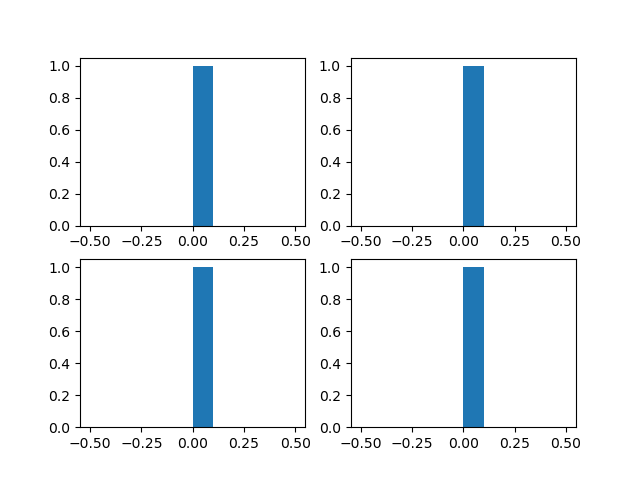

In [6]:
fig = plt.figure()
fig.add_subplot(221).hist(missings)
fig.add_subplot(222).hist(blinks)
fig.add_subplot(223).hist(technicals)
fig.add_subplot(224).hist(tracklosses)
# ax2 = plt.figure().add_subplot()
# ax2.hist(blinks)

In [7]:
viewings_subset = np.array(viewings_subset)
high_missing = viewings_subset[np.where(np.array(missings) >= 0.25)[0]]
print(len(high_missing))
print(list(high_missing))
# print(np.sum(blink_tps[0].tech_trackloss))

0
[]


In [8]:
# get fixations
fix_dfs = []
fix_tps = []
for i in range(len(filt_tps)):
    tps = filt_tps[i].copy(deep=True)
    tps = BlinkProcessor.remove_missing(tps)
    try:
        # gc = VR_IDT(tps, max_angle = 2.0)
        gc = GazeCollision(tps, angular_v_threshold=70.0)
    except AttributeError as e:
        print(e)
        print(i)
    fix_dfs.append(gc.fix_df)
    fix_tps.append(gc.timepoints)

In [10]:
# display(fix_dfs[0].style)
ind = 0
print(dwell_time(fix_dfs[ind], 'total'))
print(np.sum(fix_dfs[ind].duration_time))
print(total_p_trackloss(fix_tps[ind], 'trackloss'))
print(BlinkProcessor.total_p_trackloss(fix_tps[ind], 'trackloss'), 'trackloss')

625.0
967.0
0.0
0.0 trackloss


0
0.0


,viewing_id,algorithm,fixation_or_saccade,object,start_time,end_time,start_frame,end_frame,duration_time,duration_frame,invalid_duration,centroid_x,centroid_y,centroid_z,dispersion,mean_velocity,max_velocity,mean_acceleration,gaze_object_proportion,second_gaze_object,second_gaze_object_proportion,other_gaze_object_proportion,missing_split_group
0,alloeye_15p1_19_enc,GazeCollision,fixation,Well,1014071.000000,1014296.000000,121715.000000,121742.000000,225.000000,27.000000,0.000000,7.645377,1.314169,-2.474801,0.135807,0.005703,0.011839,0.000050,1.000000,,0.000000,0.000000,0
1,alloeye_15p1_19_enc,GazeCollision,saccade,RockClose lod_0,1014296.000000,1014388.000000,121742.000000,121753.000000,92.000000,11.000000,0.000000,4.100117,0.616065,-0.939217,0.905658,0.066720,0.137104,-0.000569,0.285714,RockClose lod_1,0.285714,0.142857,0
2,alloeye_15p1_19_enc,GazeCollision,fixation,RockClose lod_1,1014388.000000,1014463.000000,121753.000000,121762.000000,75.000000,9.000000,0.000000,1.759989,0.422520,-0.086244,0.051630,0.004586,0.011122,0.000134,1.000000,,0.000000,0.000000,0
3,alloeye_15p1_19_enc,GazeCollision,saccade,Table,1014463.000000,1014521.000000,121762.000000,121769.000000,58.000000,7.000000,0.000000,0.977033,0.595736,0.194540,0.133394,0.021710,0.033177,-0.000540,0.666667,RockClose lod_0,0.166667,0.333333,0
4,alloeye_15p1_19_enc,GazeCollision,fixation,Table,1014521.000000,1014746.000000,121769.000000,121796.000000,225.000000,27.000000,0.000000,0.587581,0.701690,0.328633,0.017211,0.000708,0.002498,0.000003,1.000000,,0.000000,0.000000,0
5,alloeye_15p1_19_enc,GazeCollision,saccade,Helmet,1014746.000000,1014788.000000,121796.000000,121801.000000,42.000000,5.000000,0.000000,0.481276,0.757489,0.444670,0.049306,0.003340,0.005167,-0.000230,0.750000,Helmet,0.250000,0.250000,0
6,alloeye_15p1_19_enc,GazeCollision,fixation,Helmet,1014788.000000,1014888.000000,121801.000000,121813.000000,100.000000,12.000000,0.000000,0.447489,0.780754,0.504650,0.007292,0.000233,0.000533,-0.000005,1.000000,,0.000000,0.000000,0
7,alloeye_15p1_19_enc,GazeCollision,saccade,Cup,1014888.000000,1015038.000000,121813.000000,121831.000000,150.000000,18.000000,0.000000,0.050777,0.771308,0.267748,0.206058,0.004629,0.011030,-0.000044,0.545455,Helmet,0.363636,0.454545,0


C:\Users\Luke\anaconda3\envs\alloeyepy\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


alloeye_15p1_19_enc
viewing: alloeye_15p1_19_enc
['Cup' 'Helmet']


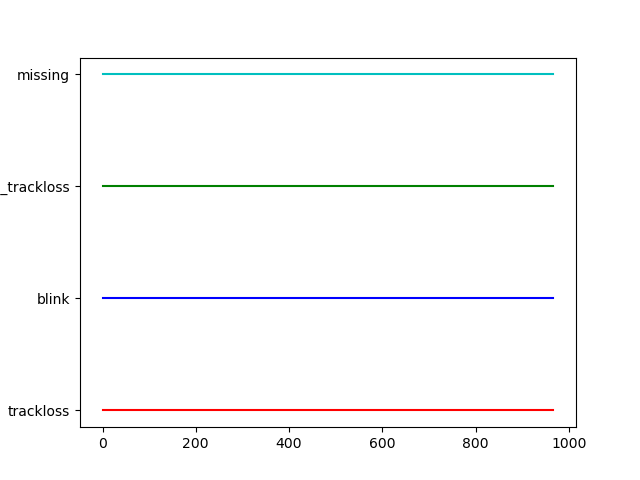

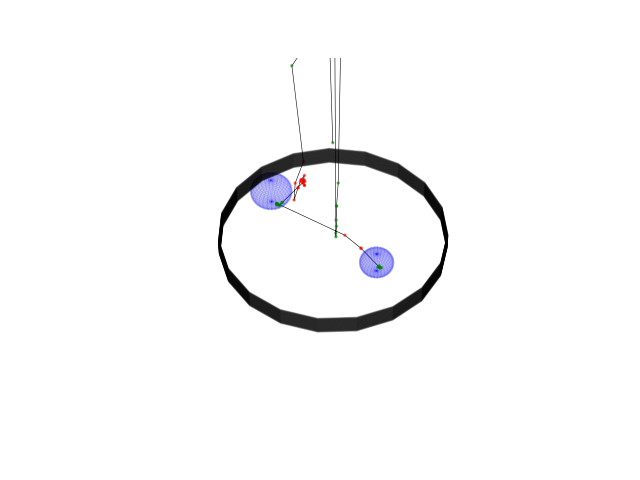

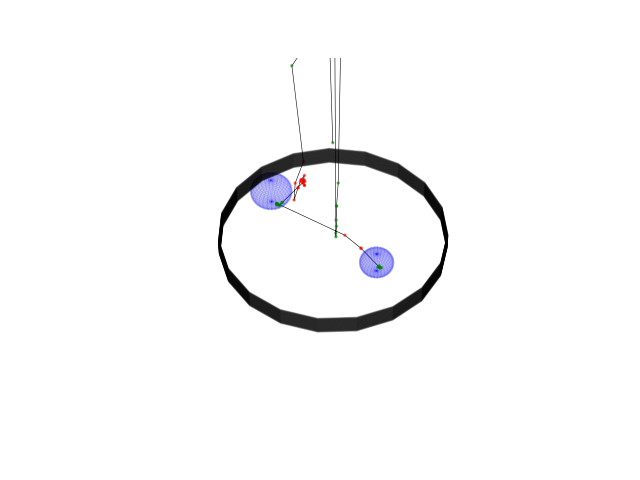

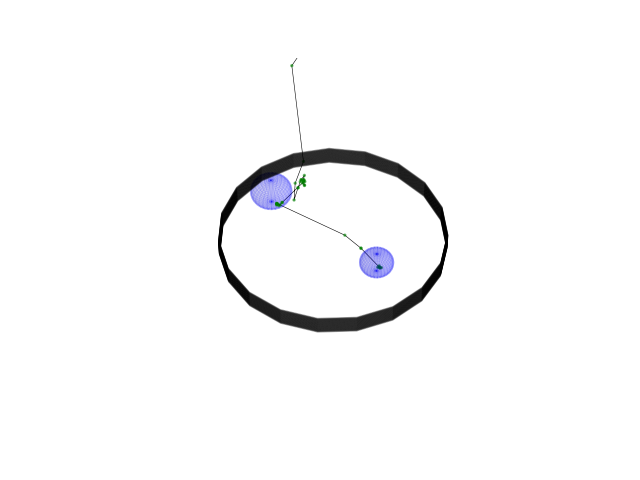

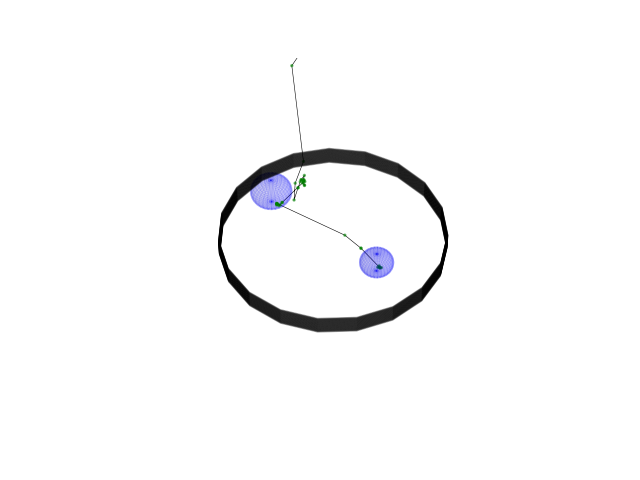

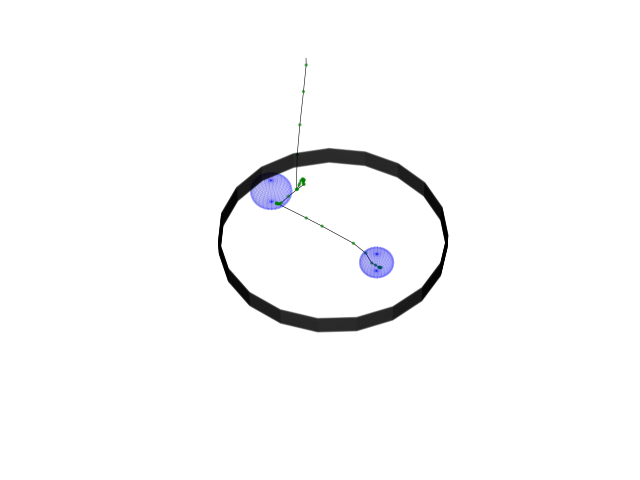

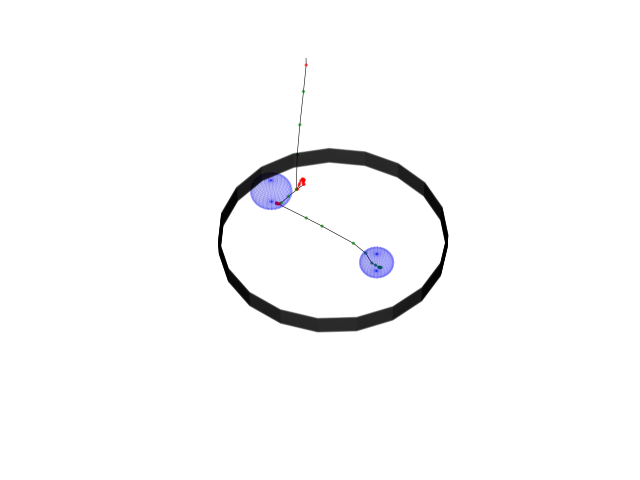

In [12]:
ind = random.randint(0, len(og_tps))
ind = 0
print(ind)
print(np.array(missings)[ind])

# print(viewings_subset)
def on_off_plot(tps, cols, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()
    
    # multipliers = list(range(1, len(cols) + 1))
    adders = [float(i) * 1.5 for i in range(len(cols))]
    t = tps.eye_timestamp_ms.to_numpy() 
    print(tps.viewing_id[0])
    t = t - t[0]
    colors = itertools.cycle(["r", "b", "g", "c", "m"])
    
    for i in range(len(cols)):
        y = np.array(tps[cols[i]].to_numpy(), dtype=float)
        y += float(adders[i])
        ax.plot(t, y, color=next(colors))
    
    ax.set_yticks(adders, cols)
    
display(fix_dfs[ind].style)
cols = ['trackloss', 'blink', 'tech_trackloss', 'missing']
on_off_plot(fix_tps[ind], cols)
raw_blink_filt_fix(ind)



In [ ]:
# plot all viewings

n_cols = 2
n_rows = int(np.ceil(len(viewings_subset)/n_cols))
print(n_viewings)

#define figure
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, subplot_kw={'projection': '3d'})
plt.subplots_adjust(left=0,
                    bottom=0,
                    right=1,
                    top=1,
                    wspace=0,
                    hspace=0)

for i, ax in enumerate(axes.flat):
    try:
        tps = blink_tps[i]
    except IndexError:
        pass
    full_objects = np.unique(tps.gaze_object)
    # array_objects = TaskObjects.array_and_invisible
    array_objects = ['InvisibleObject', *TaskObjects.array_objects]
    objects = full_objects[np.isin(full_objects,np.array(array_objects))]
    viewing_plot(tps, objects,gp_lab='missing', gp_line=True, ax=ax)

In [ ]:
for i in range(len(og_tps)):
    full_objects = np.unique(og_tps[i].gaze_object)
    # print(full_objects)
    if 'InvisibleObject' in full_objects:
        print(i)
        raw_blink_filt_fix(i)
        break
    

In [ ]:
def head_project(point_matrix, head_loc_matrix, use_head_rot=False, head_rot_matrix=None):
    """
    method to project 3d world gaze point to 2d plane with origin at head (camera) location
    and normal as head direction (camera rotation). Can use the output to calculate distance,
    velocity etc.
    :param point_matrix: numpy nd array of xzy gaze world locations n x 3
    :param head_loc_matrix: numpy nd array of xzy head world locations n x 3
    :param head_rot_matrix: numpy nd array of xzy head rotation euler angles as captured by unity n x 3
    :return: numpy nd array of xzy projected points
    """
    proj_mat = np.zeros(np.shape(point_matrix))
    length = np.shape(point_matrix)[0]
    mean_head_loc = np.mean(head_loc_matrix, axis=0)


    # define norm
    if use_head_rot:
        if head_rot_matrix is None:
            raise Exception
        else:
            mean_head_rot = np.nanmean(head_rot_matrix, axis=0)
            head_rot_x = mean_head_rot[0] - 90
            head_rot_y = 90 - mean_head_rot[1]
            head_v_x, head_v_y, head_v_z = FixationProcessor.spher2cart(1, head_rot_y, head_rot_x)
            norm = np.array([head_v_x, head_v_y, head_v_z]) * -1
    else:
        trunc_points = np.array(point_matrix)
        for i in range(trunc_points.shape[1]):
            pts = trunc_points[:, i]
            sd3 = 1 * np.nanstd(pts)
            trunc_up = np.nanmean(pts) + sd3
            trunc_down = np.nanmean(pts) - sd3
            print(f'{trunc_up}, {trunc_down}')
            trunc_points[:, i] = np.clip(pts, trunc_down, trunc_up)
        mean_point = np.nanmean(trunc_points, axis=0)
        mean_test = np.nanmean(point_matrix, axis=0)
        print(mean_point)
        print(mean_test)
        v = mean_point - mean_head_loc
        norm = v / np.linalg.norm(v)


    for i in range(length):
        x, y, z = FixationProcessor.project_3d_to_2d(norm, mean_head_loc, point_matrix[i, :])
        proj_mat[i, :] = (x[0], y[0], z[0])
    return proj_mat



In [ ]:

def head_project_plot(tps):
    # get projected points
    point_mat = TimepointProcessor.create_gaze_point_matrix(tps)
    head_loc = TimepointProcessor.create_matrix(tps, ['camera_x', 'camera_y', 'camera_z'])
    head_rot = TimepointProcessor.create_matrix(tps, ['cam_rotation_x', 'cam_rotation_y', 'cam_rotation_z'])
    proj = head_project(point_mat, head_loc)
    diff_2d = FixationProcessor.displacement_vector(proj)
    # proj = project_gaze_points(point_mat,head_rot, head_loc)
    
    # get array objects
    full_objects = np.unique(tps.gaze_object)
    array_objects = ['InvisibleObject', *TaskObjects.array_objects]
    objects = full_objects[np.isin(full_objects,np.array(array_objects))]
    print(f"viewing: {viewings[ind]}")
    print(f"{objects}")
    
    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    viewing_plot(tps, objects, 'missing', False, ax)
        # plot gaze points as points
    x, y, z = proj[:, 0], proj[:, 1], proj[:, 2] 
    lab = np.array(tps['missing'].to_numpy(), dtype=bool)
    no_lab = np.invert(lab)

    ax.scatter(x[lab], z[lab], y[lab], c='m', s=2)
    ax.scatter(x[no_lab], z[no_lab], y[no_lab], c='c', s=2)
    head_mean = np.mean(head_loc, axis=0)
    table_top = get_center('Table', tps)
    ax.plot([head_mean[0], table_top[0]], [head_mean[2], table_top[1]], [head_mean[1], table_top[2]], 'b-')
    
    ax_len = 0.75
    ax.set_xlim([table_top[0]-ax_len, table_top[0]+ax_len])
    ax.set_ylim([table_top[1]-ax_len, table_top[1]+ax_len])
    ax.set_zlim([table_top[2]-ax_len, table_top[2]+ax_len])
    # if gp_line:
    #     ax.plot(x, z, y, c='k', linewidth=0.4)
    
    

ind = random.randint(0, n_viewings-1)
ind=0
head_project_plot(blink_tps[ind])
# on_off_plot(fix_tps[ind], 'd_2d')

# CHECK THIS alloeye_52r1_13_enc - for strange offset and blink interp